# Experimenting with marker detection

The `marker_detection.py` library has functions to detect a marker in an image from Cozmo. This notebook explores how it is used; at the very end is a working example of detecting a marker in real-time with Cozmo.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mppatches
import matplotlib.image as mpimg 
from skimage import color, util
import numpy as np
import random
import os

from marker_detection import *

np.seterr(all='ignore');

Load into memory the filenames of all of the training images. In this example, `cozmo_markers_images` is a directory that contains folders of training images, as in student photo library on Piazza.

In [2]:
train_dir = 'cozmo_markers_images/'
images = {}
images_per_label = 100

for label_dir in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label_dir)
    
    if not os.path.isdir(label_dir):
        continue
        
    filenames = list(os.listdir(label_dir))
    filenames = [fn for fn in filenames if fn.endswith('.bmp')]
    
    for fn in random.sample(filenames, min(images_per_label, len(filenames))):
        images[fn] = os.path.join(label_dir, fn)

### Corner detection

Attempting to detect corners on the sides of the markers:

- Gaussian blur the image to reduce camera noise
- Use a local thresholding filter to find components (this utilizes the fact that the marker is printed on white cardstock, allowing the rectangular bars to be detected since they are dark bars on a light background)
- Obtain regions in the thresholded image
- Use a heuristic that incorporates orientation, area of the regions, and similarity to template corner images  to find two candidate corner components

This is the approach utilized by `marker_detection.detect_marker(image)`.

The following code is used to display images and markers in this notebook.

In [3]:
def print_region_properties(region):
    ''' Print relevant properties for a given region '''
    
    min_row, min_col, max_row, max_col = region.bbox
    print('Region {}:'.format(region.label))
    print('\tarea = {}'.format(region.area))
    print('\tbbox-width = {}'.format(max_col - min_col))
    print('\tbbox-height = {}'.format(max_row - min_row))
    print('\torientation = {}'.format(np.rad2deg(region.orientation)))
    print()


def plot_marker_regions_on_axis(marker, ax):
    ''' Draws the marker's candidate regions on top of the given matplotlib axis object '''
    
    regions = marker['regions']
    
    for i, region in enumerate(regions):
        min_row, min_col, max_row, max_col = region.bbox
        centroid_row, centroid_col = region.centroid

        # Label the region
        ax.text(min_col - 10, min_row - 10, region.label, color='red')

        # Mark the bounding box of the region
        patch = mppatches.Rectangle(
            (min_col, min_row), 
            max_col - min_col, 
            max_row - min_row,
            fill=None, 
            edgecolor=('red' if i == 0 else 'yellow'), 
            linewidth=1
        )
        ax.add_patch(patch)

        # Mark the centroid of the region
        ax.plot(centroid_col, centroid_row, '+g', markeredgewidth=2)
        

def plot_image_and_marker(image, marker, image_name='Original', figure_color='white'):
    ''' Draw the image and detected marker '''
    
    filtered_image = marker['filtered_image']
    
    # Display candidate marker
    fig, ax = plt.subplots(1, 4, figsize=(12, 5), facecolor=figure_color)
    
    ax[0].axis('off')
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title(image_name)    
    
    ax[1].axis('off')
    ax[1].imshow(filtered_image, cmap='gray')
    ax[1].set_title('Processed')

    ax[2].axis('off')
    ax[2].imshow(filtered_image, cmap='gray')
    ax[2].set_title('No marker found')
    
    ax[3].axis('off')
    ax[3].imshow(np.zeros((1,1)), cmap='binary')
    
    # Display the detected marker
    if marker['detected']:
        ax[2].set_title('Marker detected')
        plot_marker_regions_on_axis(marker, ax[2])
        
        ax[3].imshow(marker['unwarped_image'], cmap='gray')
        ax[3].set_title('Unwarped marker')


Test the marker detection code on a small sample of the training data

/Users/sajidanwar/.local/share/virtualenvs/RobotTA-lL6fprqy/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


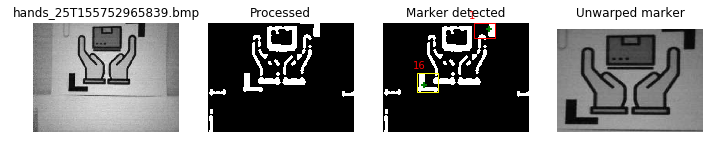

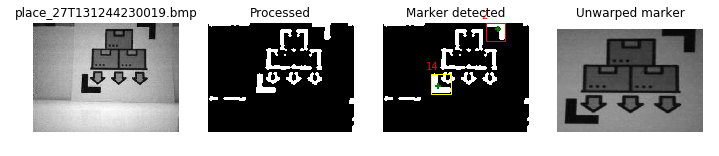

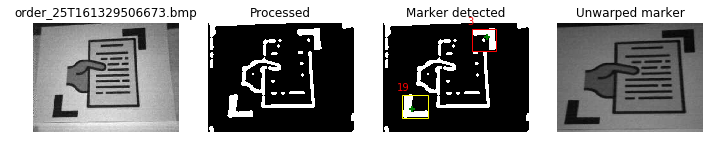

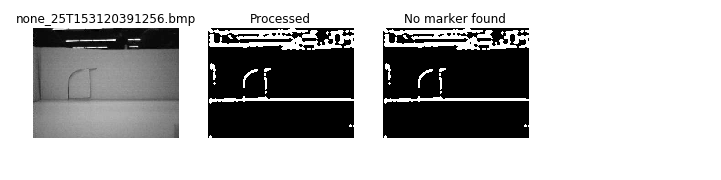

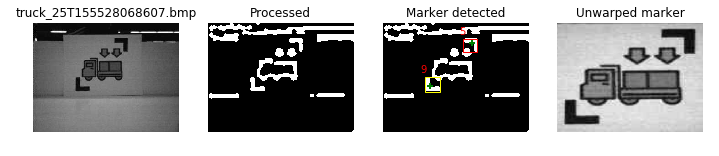

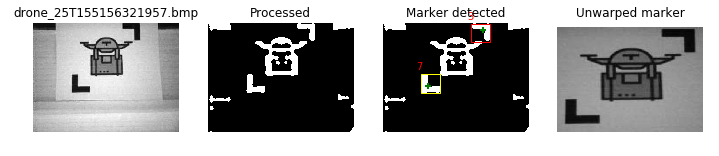

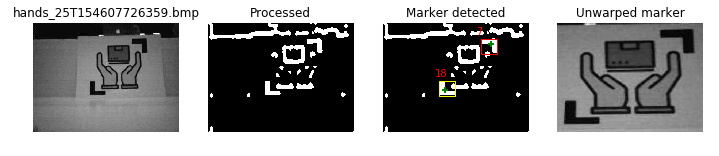

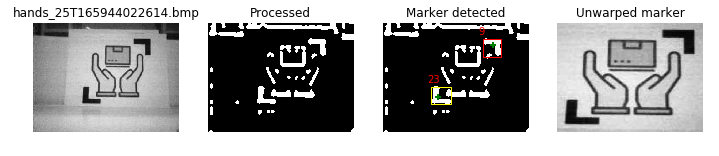

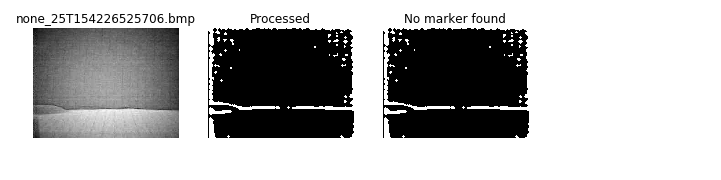

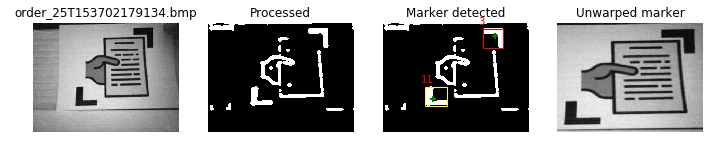

In [4]:
sample_images = images.items()
num_images = 10

# Take a random sample of images
for image_name, image_path in random.sample(sample_images, num_images):
    
    # Get the original image at this path
    image_gray = image_for_filename(image_path)
    
    # Detect the marker in the image
    marker = detect_marker(image_gray)
    
    # Show information about the given image and detected marker (if found)
    plot_image_and_marker(image_gray, marker, image_name=image_name)

Now every image in the training set will be processed and visualized.

NOTE: The following code is commented out because it can take some time to run. However, it runs marker detection on every image in the training dataset and highlights incorrect results (e.g.: not detecting a marker that is actually there). This makes it useful when tweaking `marker_detection.py` to see how it improves errors.

In [5]:
# # Keep track of the detected candidate rectangles for each image
# results = []

# for image_name, image_path in list(images.items()):
#     image_gray = image_for_filename(image_path)
    
#     # Try to detect the marker
#     marker = marker_candidate_for_image(image_gray)
    
#     # Determine the ground truth of existence of a marker based on filename
#     gt_marker_exists = not image_name.startswith('none')
#     correct = (marker['detected'] == gt_marker_exists)
    
#     results.append((correct, image_name, image_gray, marker))
        
# for result in sorted(results):
#     correct, image_name, image_gray, marker = result
    
#     figure_color = 'white' if correct else '#FFE0E0'
#     plot_image_and_marker(image_gray, marker, image_name, figure_color)

### Example: detect in real-time

This working example connects to a Cozmo and performs marker detection in real-time.

In [ ]:
from IPython import display

import cozmo
import time
import logging
import sys

stop = False

# NOTE: Notebook specific
def notebook_display_marker(image, marker):
    plt.close('all')
    plot_image_and_marker(image, marker)

    display.clear_output(wait=True)
    display.display(plt.gcf())

def run(robot: cozmo.robot.Robot):
    '''The run method runs once Cozmo is connected.'''
    global stop
    
    robot.camera.image_stream_enabled = True
    robot.camera.color_image_enabled = False
    robot.camera.enable_auto_exposure()
    robot.set_head_angle(cozmo.util.degrees(0)).wait_for_completed()
 
    while not stop: 
        time.sleep(0.05)
        
        if not robot.world.latest_image:
            continue
            
        # Get the latest image from Cozmo and convert it to grayscale
        image = np.array(robot.world.latest_image.raw_image)
        image = color.rgb2gray(image)
        
        # Detect the marker
        marker = detect_marker(image)
        
        # NOTE: Notebook specific
        notebook_display_marker(image, marker)
        
        # Check if a marker was detected
        if marker['detected']:
            
            # Get the cropped, unwarped image of just the marker
            marker_image = marker['unwarped_image']
            
#             # Use the marker image for improved classification, e.g.:
#             marker_type = my_classification_function(marker_image)
            
#             # Find the marker width and use it for e.g.: distance calculation
#             marker_width = marker['marker_width']
#             # ...
        
def on_sdk_conn(sdk_conn):
    robot = sdk_conn.wait_for_robot()
    run(robot)

try:
    stop = False
    cozmo.connect(on_sdk_conn)
except cozmo.exceptions.ConnectionError:
    print('Could not connect to Cozmo')
except KeyboardInterrupt:
    print('Stopped by user')
    stop = True